## Introduction
We have a single cell  gene expression profile on 4 vascular site: hepatic vein (HV), peripheral artery (PA), peripheral vein (PV) and portal vein (PoV).

We aim to find important gene between neighbour sites. Thus, there are 3 binary classification tasks.

Before performing machine learning, the DEG analysis have already done in 2 methods based on Deseq2, edgeR and limma.
We take the intersection of 2 methods as features of machine learning tasks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Mounted at /content/drive


In [ ]:
from __future__ import print_function
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time

# import vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import librares for machine learning
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# import evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_recall_fscore_support, balanced_accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance

# Permutaion importance
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold

# dimension reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import DBSCAN

In [ ]:
import os
os.chdir('/content/drive/MyDrive')

# Load datasets

In [ ]:
df_original = pd.read_csv('/content/drive/MyDrive/Data mining project/CTC.csv', sep = ',')
df_original = df_original.set_index('gene')

In [ ]:
df_deseq2_g1 = pd.read_csv('/content/drive/MyDrive/Data mining project/gc/HA_PA_important.csv')
df_deseq2_g1 = df_deseq2_g1.set_index('gene')

In [ ]:
df_deseq2_g2 = pd.read_csv('/content/drive/MyDrive/Data mining project/gc/PA_PV_important.csv')
df_deseq2_g2 = df_deseq2_g2.set_index('gene')

In [ ]:
df_deseq2_g3 = pd.read_csv('/content/drive/MyDrive/Data mining project/gc/PV_POV_important.csv')
df_deseq2_g3 = df_deseq2_g3.set_index('gene')

In [ ]:
df_limma_g1 = pd.read_csv('/content/drive/MyDrive/Data mining project/zz/group1.csv')
df_limma_g1 = df_limma_g1.set_index('gene')

In [ ]:
df_limma_g2 = pd.read_csv('/content/drive/MyDrive/Data mining project/zz/group2.csv')
df_limma_g2 = df_limma_g2.set_index('gene')

In [ ]:
df_limma_g3 = pd.read_csv('/content/drive/MyDrive/Data mining project/zz/group3.csv')
df_limma_g3 = df_limma_g3.set_index('gene')

# Define a z-score normalization to get normal distribution

In [ ]:
df_original_1 = df_original.T

In [ ]:
# normalization
def norm_(df):
  # df = df.drop('label', axis = 1)
  xmean = np.mean(df,0)
  std = np.std(df,0)
  return (df-xmean)/std

In [ ]:
df_original_1 = norm_(df_original_1)
df_original = df_original_1.T

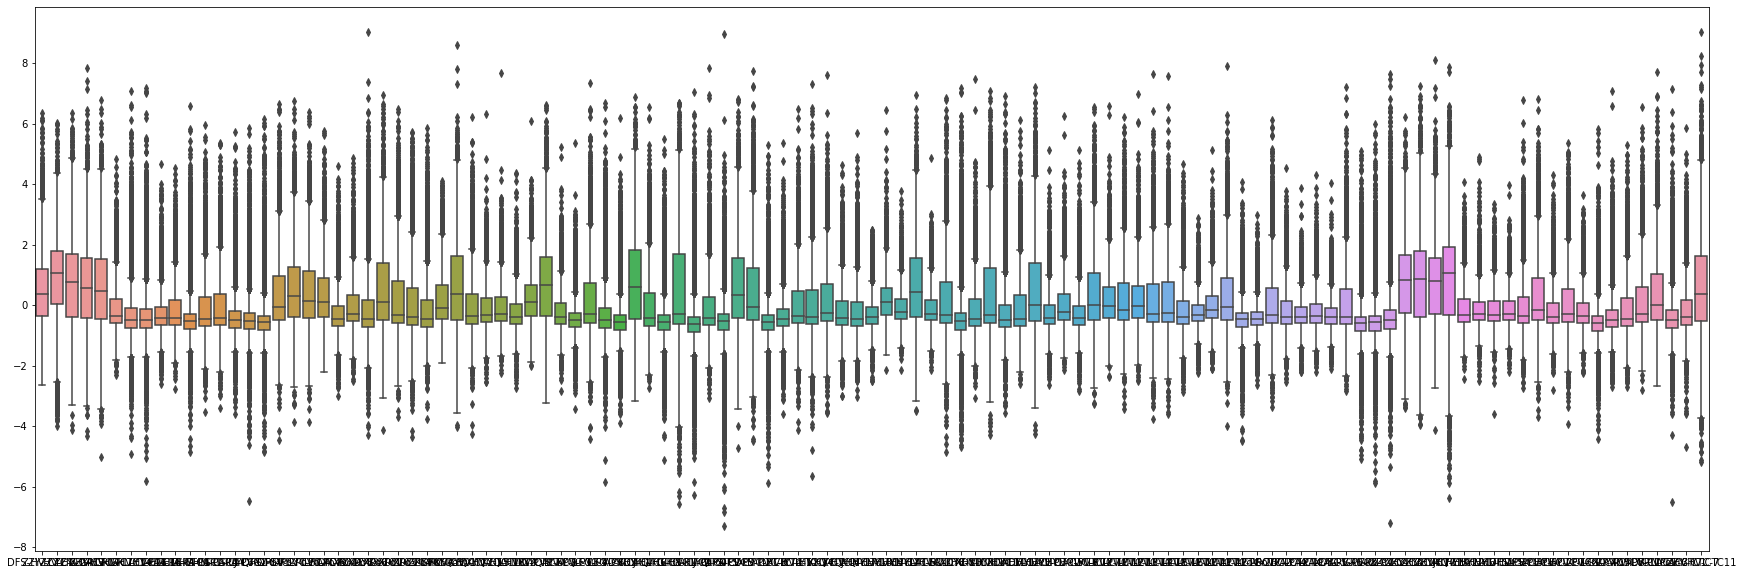

In [ ]:
plt.figure(figsize=(30, 10))
sns.boxplot(data = df_original)

# Select the intersection of genes

In [ ]:
def inter_gene_selection(df_1, df_2, df_original):
  # get the indexs of two datasets
  index_df_1 = list(df_1.index)
  index_df_2 = list(df_2.index)

  # select the common index
  index_inter = [i for i in index_df_1 if i in index_df_2]
  # index_inter = list(set(df_1).intersection(set(df_2)))

  # select intersections genes from original dataset
  df_original_T = df_original.T
  df_inter_gene = df_original_T[index_inter]
  n_inter_gene = len(df_inter_gene.T)

  return df_inter_gene, n_inter_gene

In [ ]:
df_inter_g1, n_gene_g1 = inter_gene_selection(df_deseq2_g1, df_limma_g1, df_original)
df_inter_g2, n_gene_g2 = inter_gene_selection(df_deseq2_g2, df_limma_g2, df_original)
df_inter_g3, n_gene_g3 = inter_gene_selection(df_deseq2_g3, df_limma_g3, df_original)

In [ ]:
print(n_gene_g1)
print(n_gene_g2)
print(n_gene_g3)

52
85
58


# Data pre-processing

In [ ]:
df_group = pd.read_csv('/content/drive/MyDrive/Data mining project/group.csv')
df_group

,0,patient,location,color
0,DFS-HV-CTC-5,DFS,HV,red
1,ZZY-HV-CTC24,ZZY,HV,red
2,ZZY-HV-CTC5,ZZY,HV,red
3,ZZY-HV-CTC6,ZZY,HV,red
4,ZZY-HV-CTC7,ZZY,HV,red
...,...,...,...,...
108,XDY-PV-CTC2,XDY,PV,blue
109,XDY-PV-CTC3,XDY,PV,blue
110,GRL-PoV-CTC1,GRL,PoV,green
111,LYT-HV-CTC-7,LYT,HV,red


In [ ]:
# Convert the location to a column with integer labels
# HV - > 0
# PA - > 1
# PV - > 2
# PoV - > 3
label_encoder = LabelEncoder()
df_group['location'] = label_encoder.fit_transform(df_group['location'])

In [ ]:
df_index = df_group[['location']]

In [ ]:
df_original.shape[0]

13005

In [ ]:
df_original.shape[1]

113

In [ ]:
# combine the label to the original dataset
df_original = df_original.T
df_original.insert(df_original.shape[1], 'label', df_index[['location']])
df_original_comb = df_original
df_original_comb

gene,WASH7P,LOC729737,LOC100132287,LOC100133331,LOC100288069,LOC100287934,LINC00115,LINC01128,FAM41C,LOC284600,...,UTY,TMSB4Y,NCRNA00185,CD24,TTTY14,TXLNGY,KDM5D,EIF1AY,RPS4Y2,label
DFS-HV-CTC-5,2.083054,-0.801162,1.057602,2.528727,-0.487023,-0.383906,-0.365311,-0.168108,0.792000,2.427794,...,-1.008301,0.364621,-0.477897,-0.091115,-0.560731,1.455753,-0.612220,0.934344,-0.797917,0
ZZY-HV-CTC24,-0.953683,0.691014,0.708957,1.069015,0.762770,0.787439,1.348944,0.289556,0.060691,-0.726614,...,0.006661,-1.025571,1.629989,2.807042,0.342044,0.954778,0.597586,0.963568,1.801202,0
ZZY-HV-CTC5,-0.433971,-0.571474,-0.503694,-0.465437,-0.790952,1.236701,-0.365311,-0.623567,-0.230958,-0.726614,...,1.122182,-0.263785,0.972355,2.788558,0.784159,0.677334,-0.592539,0.387877,1.981373,0
ZZY-HV-CTC6,-1.024901,-0.610334,-0.823148,-0.458994,-0.399875,-0.383906,2.470860,1.501136,-0.564868,-0.726614,...,0.741356,-0.381123,0.701487,3.139724,2.302595,-0.206864,0.127486,1.116877,1.623136,0
ZZY-HV-CTC7,-0.912977,-0.115558,-0.655421,-0.531994,1.046001,1.355493,-0.365311,2.149721,-0.670943,-0.726614,...,-0.115769,0.143826,-0.477897,3.158480,-0.560731,-0.864778,-0.612220,0.962348,1.857731,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XDY-PV-CTC2,1.226436,0.276296,0.688861,-0.084055,-0.790952,2.377560,-0.365311,0.991080,-0.670943,-0.726614,...,0.551397,-0.431567,0.274746,-0.479788,-0.560731,-0.037152,1.047570,-0.114399,0.966656,2
XDY-PV-CTC3,0.861723,1.096139,1.736799,0.312316,-0.790952,2.426030,-0.365311,-0.623567,0.165641,-0.726614,...,0.607228,0.791722,-0.477897,-0.479788,2.641139,1.265766,2.959906,0.206427,1.569944,2
GRL-PoV-CTC1,-1.880765,-0.801162,-0.911720,-0.531994,-0.470961,-0.383906,-0.021730,1.473985,-0.670943,-0.726614,...,-1.008301,0.918777,-0.477897,0.545015,-0.560731,-0.864778,-0.265384,0.786328,-0.797917,3
LYT-HV-CTC-7,0.300634,-0.801162,-0.911720,-0.531994,-0.790952,-0.383906,-0.365311,-0.623567,-0.670943,0.337846,...,-0.775475,0.486028,-0.477897,-0.479788,-0.560731,-0.864778,-0.612220,0.124361,-0.797917,0


In [ ]:
df_original = df_original.drop('label', axis = 1)

In [ ]:
# define a dataset to combine the label with the data
def add_label(df, df_index):
  # df = df.T
  df.insert(df.shape[1], 'label', df_index[['location']])
  df_comb = df
  return df_comb

In [ ]:
df_inter_g1 = add_label(df_inter_g1, df_index)
df_inter_g2 = add_label(df_inter_g2, df_index)
df_inter_g3 = add_label(df_inter_g3, df_index)

In [ ]:
df_1 = df_inter_g1[(df_inter_g1['label'] == 0) | (df_inter_g1['label'] == 1)] 
df_2 = df_inter_g2[(df_inter_g1['label'] == 1) | (df_inter_g1['label'] == 2)] 
df_3 = df_inter_g3[(df_inter_g1['label'] == 2) | (df_inter_g1['label'] == 3)] 

In [ ]:
# the sample size and number of features for each binary classification task
print(np.shape(df_1))
print(np.shape(df_2))
print(np.shape(df_3))

(57, 53)
(52, 86)
(56, 59)


In [ ]:
def box(df, title):
  plt.figure(figsize = (15,8))
  sns.boxplot(data = df.drop('label', axis = 1))
  plt.title(title)
  plt.xticks(rotation = '90')
  plt.show()

# Check distribution

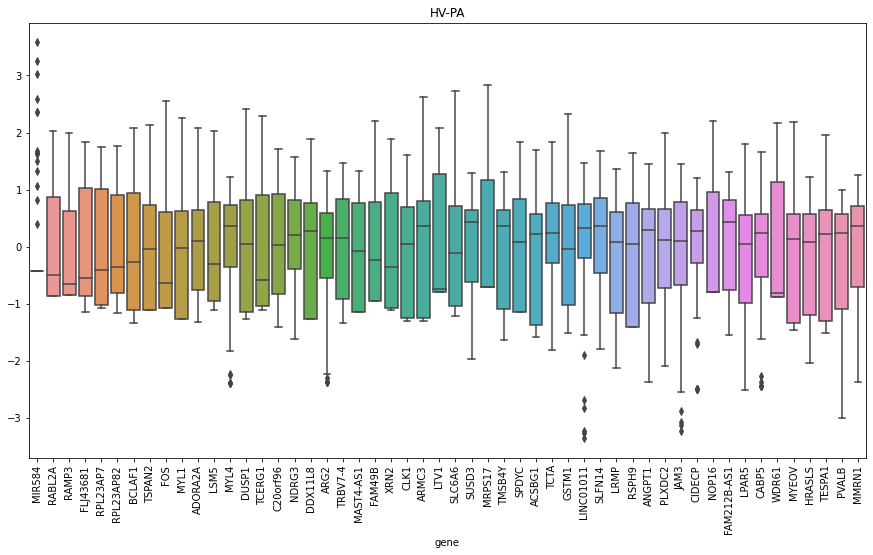

In [ ]:
box(df_1, 'HV-PA')

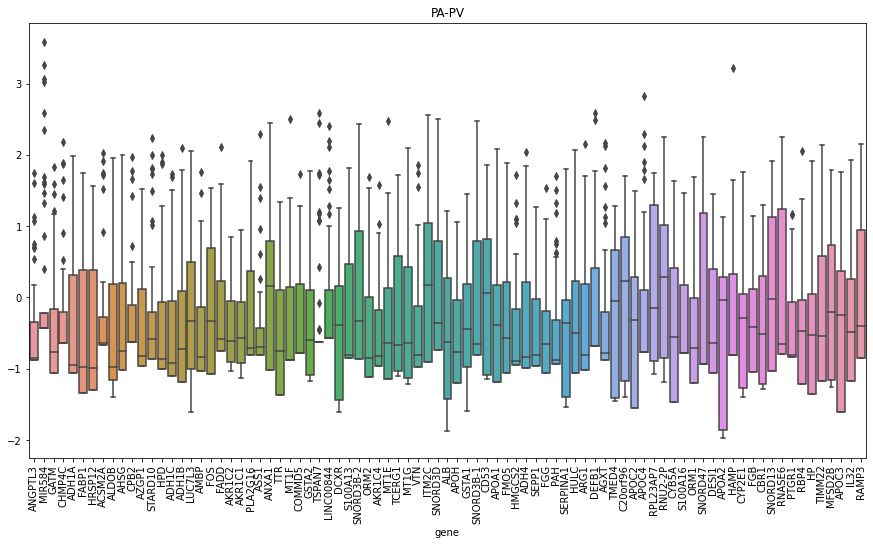

In [ ]:
box(df_2, 'PA-PV')

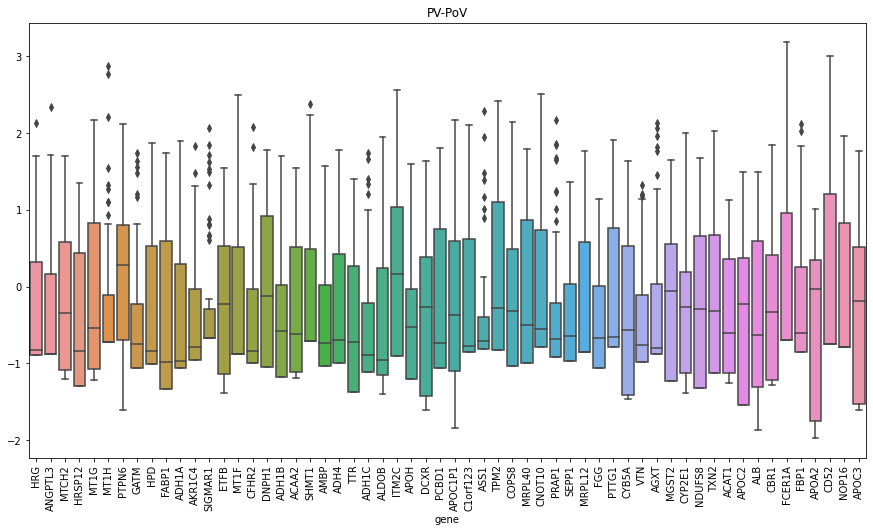

In [ ]:
box(df_3, 'PV-PoV')

# Select important genes using decision tree

In [ ]:
def Decision_tree(df, pos_label):
  # define dataset and label
  X = df.drop(['label'], axis = 1)
  y = df['label']

  # split the dataset to trainset and testset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, shuffle=True, stratify = y)

  # train the model
  dtree = DecisionTreeClassifier(criterion="entropy", random_state=123,
                                max_depth=4,
                                min_samples_leaf=5, class_weight = 'balanced')
  dtree.fit(X_train, y_train)
  
  # prediction
  pred_train = dtree.predict(X_train)
  pred_test = dtree.predict(X_test)
  
  # accuracy
  train_acc = balanced_accuracy_score(y_train, pred_train)
  test_acc = balanced_accuracy_score(y_test, pred_test)
  print ("trainset accuracy: {0:.2f}, testset accuracy: {1:.2f}".format(train_acc, test_acc))
  
  # other four evaluation metrics
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    CM = confusion_matrix(y_test, pred_test, labels = [0, 1])
  elif (set(df['label']) == {0, 1}) & (pos_label == 1): 
    CM = confusion_matrix(y_test, pred_test, labels = [1, 0])
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    CM = confusion_matrix(y_test, pred_test, labels = [1, 2])
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 1])
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 3])  
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    CM = confusion_matrix(y_test, pred_test, labels = [3, 2])     
  precision = CM[0, 0] / (CM[0, 0] + CM[1, 0])
  sensitivity = CM[0, 0] / (CM[0, 0] + CM[0, 1])
  specificity = CM[1, 1]/(CM[1, 0] + CM[1, 1])
  F1 = (2 * precision * sensitivity) / (precision + sensitivity)
  print("precision: {0:.2f}, sensitivity: {1:.2f}, specificity: {2:.2f}, F1-score: {3:.2f}".format(precision, sensitivity, specificity, F1))  

  # plot heatmap for confusion matrix
  fig, ax = plt.subplots(figsize=(8, 4.5))
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    tick_label = [0, 1]
  elif (set(df['label']) == {0, 1}) & (pos_label == 1):
    tick_label = [1, 0]
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    tick_label = [1, 2]
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    tick_label = [2, 1]
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    tick_label = [2, 3]
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    tick_label = [3, 2]
  sns.heatmap(CM, fmt='.0f', cmap="Reds",
              square=True, linewidths=.5, annot=True, xticklabels = tick_label, yticklabels = tick_label)
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.title('Confusion Matrix of Test Set')
  plt.show()

  # plot ROC Cruve 
  labels = np.unique(df['label'].to_numpy())
  if pos_label == labels[0]:
    class_index = 0
  elif pos_label == labels[1]:
    class_index =1
  prob_train = dtree.predict_proba(X_train)
  predict_train = prob_train[:, class_index]
  fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predict_train, pos_label = pos_label)

  prob_test = dtree.predict_proba(X_test)
  predict_test = prob_test[:, class_index]
  fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predict_test, pos_label = pos_label)

  roc_auc_train = auc(fpr_train, tpr_train)
  roc_auc_test = auc(fpr_test, tpr_test)
  plt.title("ROC Curve of Decision Tree")
  plt.plot(fpr_train, tpr_train, label="AUC(train) = %0.2f" % roc_auc_train)
  plt.plot(fpr_test, tpr_test, label="AUC(test) = %0.2f" % roc_auc_test)
  plt.legend(loc="lower right")
  plt.plot([0, 1], [0, 1],  color='grey', linestyle='--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.show()

  plt.figure(figsize=(6, 4))
  sorted_idx = dtree.feature_importances_.argsort()
  plt.xlabel("Decision Tree Feature Importance")
  plt.barh(dtree.feature_names_in_[sorted_idx][-10:], dtree.feature_importances_[sorted_idx][-10:])

  plt.figure(figsize=(6, 4))
  perm_importance = permutation_importance(dtree, X_train, y_train)
  sorted_idx = perm_importance.importances_mean.argsort()
  plt.barh(X_train.columns[sorted_idx][-10: ], perm_importance.importances_mean[sorted_idx][-10: ])
  plt.xlabel("Decision Tree Permutation Importance")

  perm = PermutationImportance(dtree).fit(X_train, y_train)
  return eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top = 10)

trainset accuracy: 0.95, testset accuracy: 0.96
precision: 0.75, sensitivity: 1.00, specificity: 0.92, F1-score: 0.86


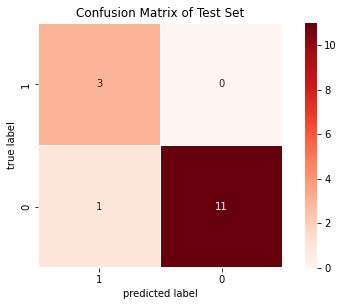

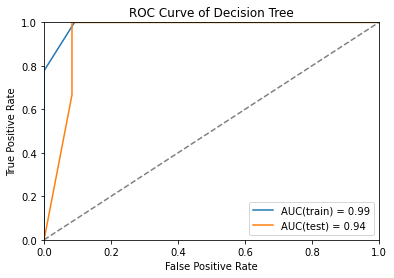

Weight,Feature
0.1667 ± 0.0673,TCERG1
0.1143 ± 0.0555,FOS
0 ± 0.0000,MAST4-AS1
0 ± 0.0000,ARG2
0 ± 0.0000,FAM49B
0 ± 0.0000,MMRN1
0 ± 0.0000,TRBV7-4
0 ± 0.0000,C20orf96
0 ± 0.0000,DDX11L8
0 ± 0.0000,NDRG3


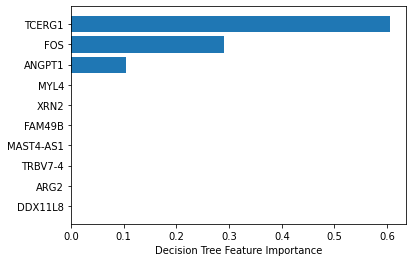

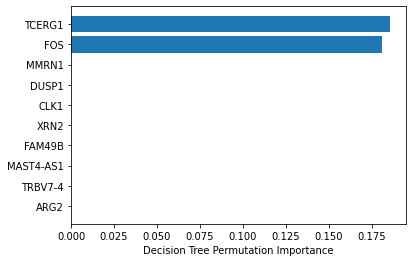

In [ ]:
Decision_tree(df_1, 1)

trainset accuracy: 0.97, testset accuracy: 0.40
precision: 0.73, sensitivity: 0.80, specificity: 0.00, F1-score: 0.76


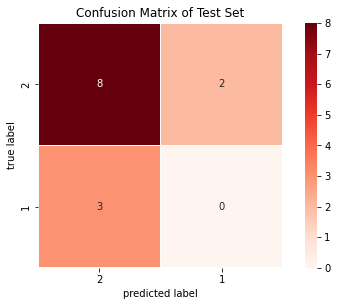

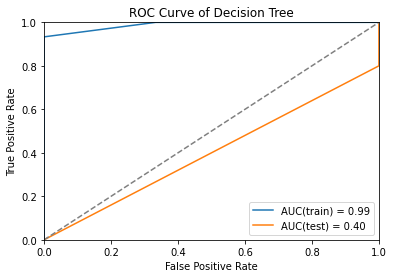

Weight,Feature
0.3179 ± 0.0768,APOH
0 ± 0.0000,S100A13
0 ± 0.0000,COMMD5
0 ± 0.0000,MT1F
0 ± 0.0000,ANXA1
0 ± 0.0000,TTR
0 ± 0.0000,ASS1
0 ± 0.0000,LINC00844
0 ± 0.0000,GSTA2
0 ± 0.0000,TSPAN7


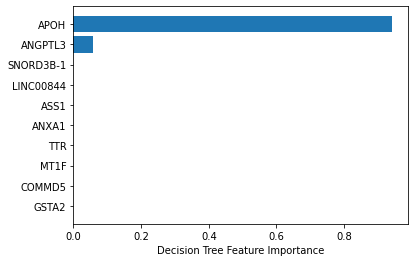

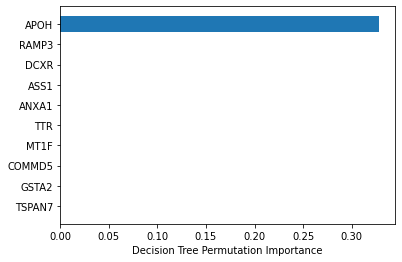

In [ ]:
Decision_tree(df_2, 2)

trainset accuracy: 0.97, testset accuracy: 0.95
precision: 0.80, sensitivity: 1.00, specificity: 0.90, F1-score: 0.89


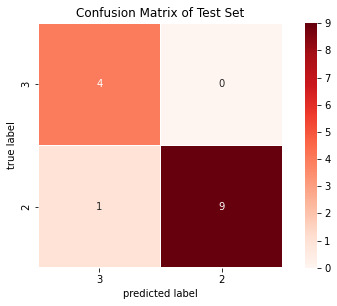

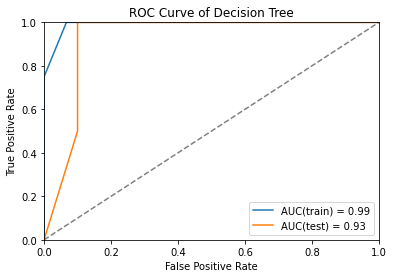

Weight,Feature
0.1810 ± 0.0486,MTCH2
0.1762 ± 0.0713,ALDOB
0 ± 0.0000,ADH1C
0 ± 0.0000,DCXR
0 ± 0.0000,DNPH1
0 ± 0.0000,AMBP
0 ± 0.0000,SHMT1
0 ± 0.0000,ACAA2
0 ± 0.0000,ADH1B
0 ± 0.0000,APOC3


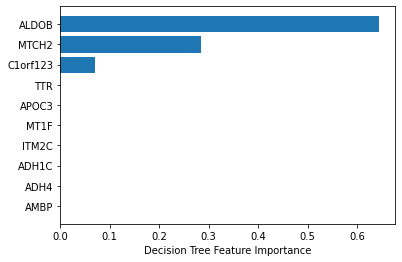

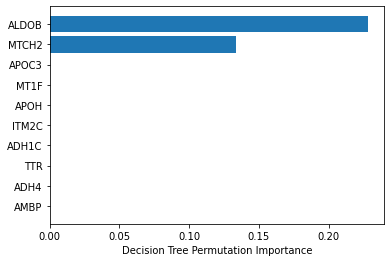

In [ ]:
Decision_tree(df_3, 3)

# Select important genes using random forest

In [ ]:
def Random_forest(df, pos_label):
  # define dataset and label
  X = df.drop(['label'], axis = 1)
  y = df['label']

  # split the dataset to trainset and testset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, shuffle=True, stratify = y)

  # train the model
  forest = RandomForestClassifier(
      n_estimators=10, criterion="entropy",
      max_depth=4, min_samples_leaf=5, class_weight = 'balanced')
  forest.fit(X_train, y_train)

  # prediction
  pred_train = forest.predict(X_train)
  pred_test = forest.predict(X_test)
  
  # accuracy
  train_acc = balanced_accuracy_score(y_train, pred_train)
  test_acc = balanced_accuracy_score(y_test, pred_test)
  print ("trainset accuracy: {0:.2f}, testset accuracy: {1:.2f}".format(train_acc, test_acc))
  
  # other four evaluation metrics
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    CM = confusion_matrix(y_test, pred_test, labels = [0, 1])
  elif (set(df['label']) == {0, 1}) & (pos_label == 1): 
    CM = confusion_matrix(y_test, pred_test, labels = [1, 0])
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    CM = confusion_matrix(y_test, pred_test, labels = [1, 2])
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 1])
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 3])  
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    CM = confusion_matrix(y_test, pred_test, labels = [3, 2])      
  precision = CM[0, 0] / (CM[0, 0] + CM[1, 0])
  sensitivity = CM[0, 0] / (CM[0, 0] + CM[0, 1])
  specificity = CM[1, 1]/(CM[1, 0] + CM[1, 1])
  F1 = (2 * precision * sensitivity) / (precision + sensitivity)
  print("precision: {0:.2f}, sensitivity: {1:.2f}, specificity: {2:.2f}, F1-score: {3:.2f}".format(precision, sensitivity, specificity, F1))  

  # plot heatmap for confusion matrix
  fig, ax = plt.subplots(figsize=(8, 4.5))
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    tick_label = [0, 1]
  elif (set(df['label']) == {0, 1}) & (pos_label == 1):
    tick_label = [1, 0]
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    tick_label = [1, 2]
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    tick_label = [2, 1]
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    tick_label = [2, 3]
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    tick_label = [3, 2]
  sns.heatmap(CM, fmt='.0f', cmap="Reds",
              square=True, linewidths=.5, annot=True, xticklabels = tick_label, yticklabels = tick_label)
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.title('Confusion Matrix of Test Set')
  plt.show()
  
  # plot ROC Cruve 
  labels = np.unique(df['label'].to_numpy())
  if pos_label == labels[0]:
    class_index = 0
  elif pos_label == labels[1]:
    class_index =1
  prob_train = forest.predict_proba(X_train)
  predict_train = prob_train[:, class_index]
  fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predict_train, pos_label = pos_label)

  prob_test = forest.predict_proba(X_test)
  predict_test = prob_test[:, class_index]
  fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predict_test, pos_label = pos_label)

  roc_auc_train = auc(fpr_train, tpr_train)
  roc_auc_test = auc(fpr_test, tpr_test)
  # plt.figure(figsize = (8, 4.5))
  plt.title("ROC Curve")
  plt.plot(fpr_train, tpr_train, label="AUC(train) = %0.2f" % roc_auc_train)
  plt.plot(fpr_test, tpr_test, label="AUC(test) = %0.2f" % roc_auc_test)
  plt.legend(loc="lower right")
  plt.plot([0, 1], [0, 1],  color='grey', linestyle='--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.show()

  plt.figure(figsize=(6, 4))
  sorted_idx = forest.feature_importances_.argsort()
  plt.xlabel("Random Forest Feature Importance")
  plt.barh(forest.feature_names_in_[sorted_idx][-10:], forest.feature_importances_[sorted_idx][-10:])

  plt.figure(figsize=(6, 4))
  perm_importance = permutation_importance(forest, X_train, y_train)
  sorted_idx = perm_importance.importances_mean.argsort()
  plt.barh(X_train.columns[sorted_idx][-10: ], perm_importance.importances_mean[sorted_idx][-10: ])
  plt.xlabel("Random Forest Permutation Importance")

  perm = PermutationImportance(forest).fit(X_train, y_train)
  return eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top = 10)

trainset accuracy: 0.91, testset accuracy: 0.62
precision: 0.50, sensitivity: 0.33, specificity: 0.92, F1-score: 0.40


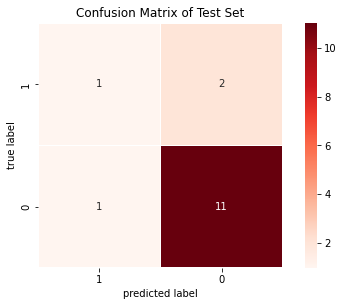

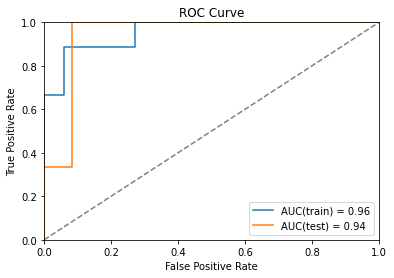

Weight,Feature
0.0476 ± 0.0522,LSM5
0.0333 ± 0.0233,TRBV7-4
0.0333 ± 0.0233,DDX11L8
0.0333 ± 0.0233,XRN2
0.0238 ± 0.0000,SUSD3
0.0143 ± 0.0381,FAM49B
0.0095 ± 0.0233,MAST4-AS1
0.0095 ± 0.0233,ARMC3
0.0048 ± 0.0356,PVALB
0.0000 ± 0.0301,JAM3


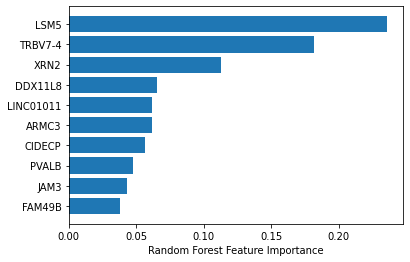

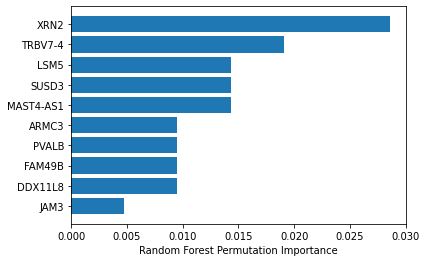

In [ ]:
Random_forest(df_1, 1)

trainset accuracy: 0.95, testset accuracy: 0.90
precision: 1.00, sensitivity: 0.80, specificity: 1.00, F1-score: 0.89


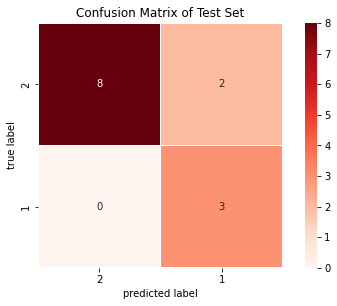

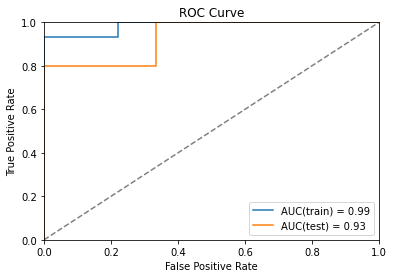

Weight,Feature
0.0256 ± 0.0000,CBR1
0.0205 ± 0.0205,AKR1C2
0.0154 ± 0.0251,LUC7L3
0.0154 ± 0.0251,CHMP4C
0.0103 ± 0.0251,ITM2C
0.0103 ± 0.0251,ANGPTL3
0 ± 0.0000,COMMD5
0 ± 0.0000,S100A13
0 ± 0.0000,LINC00844
0 ± 0.0000,DCXR


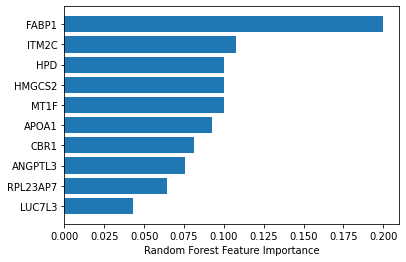

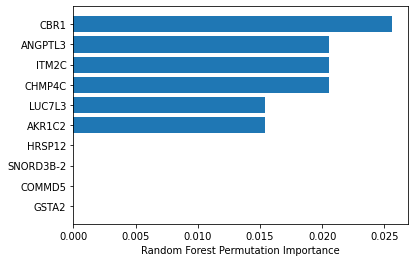

In [ ]:
Random_forest(df_2, 2)

trainset accuracy: 0.98, testset accuracy: 0.88
precision: 1.00, sensitivity: 0.75, specificity: 1.00, F1-score: 0.86


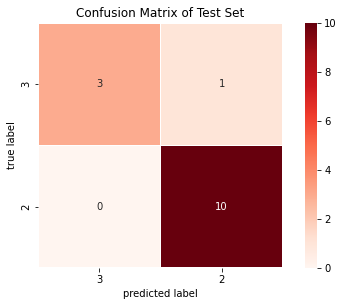

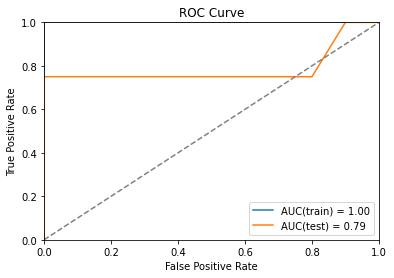

Weight,Feature
0.0333 ± 0.0233,CBR1
0.0238 ± 0.0000,PTPN6
0.0190 ± 0.0190,MTCH2
0.0190 ± 0.0190,DNPH1
0.0143 ± 0.0233,CNOT10
0.0143 ± 0.0233,TPM2
0 ± 0.0000,ADH4
0 ± 0.0000,SHMT1
0 ± 0.0000,ACAA2
0 ± 0.0000,AMBP


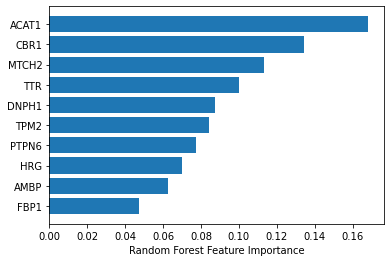

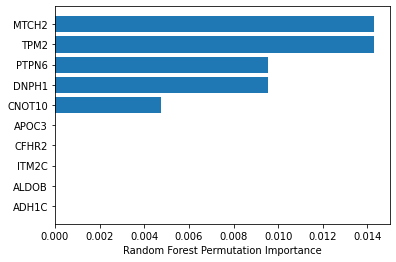

In [ ]:
Random_forest(df_3, 3)

# Select important genes using SVC

In [ ]:
def svc(df, pos_label):
  # define dataset and label
  X = df.drop(['label'], axis = 1)
  y = df['label']

  # split the dataset to trainset and testset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=19882, shuffle=True, stratify = y)

  # train the model
  svc = SVC(kernel = 'linear', probability = True, class_weight = 'balanced')
  svc.fit(X_train, y_train)

  # prediction
  pred_train = svc.predict(X_train)
  pred_test = svc.predict(X_test)
  
  # accuracy
  train_acc = balanced_accuracy_score(y_train, pred_train)
  test_acc = balanced_accuracy_score(y_test, pred_test)
  print ("trainset accuracy: {0:.2f}, testset accuracy: {1:.2f}".format(train_acc, test_acc))
  
  # other four evaluation metrics
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    CM = confusion_matrix(y_test, pred_test, labels = [0, 1])
  elif (set(df['label']) == {0, 1}) & (pos_label == 1): 
    CM = confusion_matrix(y_test, pred_test, labels = [1, 0])
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    CM = confusion_matrix(y_test, pred_test, labels = [1, 2])
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 1])
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 3])  
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    CM = confusion_matrix(y_test, pred_test, labels = [3, 2])       
  precision = CM[0, 0] / (CM[0, 0] + CM[1, 0])
  sensitivity = CM[0, 0] / (CM[0, 0] + CM[0, 1])
  specificity = CM[1, 1]/(CM[1, 0] + CM[1, 1])
  F1 = (2 * precision * sensitivity) / (precision + sensitivity)
  print("precision: {0:.2f}, sensitivity: {1:.2f}, specificity: {2:.2f}, F1-score: {3:.2f}".format(precision, sensitivity, specificity, F1))  

  # plot heatmap for confusion matrix
  fig, ax = plt.subplots(figsize=(8, 4.5))
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    tick_label = [0, 1]
  elif (set(df['label']) == {0, 1}) & (pos_label == 1):
    tick_label = [1, 0]
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    tick_label = [1, 2]
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    tick_label = [2, 1]
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    tick_label = [2, 3]
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    tick_label = [3, 2]
  sns.heatmap(CM, fmt='.0f', cmap="Reds",
              square=True, linewidths=.5, annot=True, xticklabels = tick_label, yticklabels = tick_label)
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.title('Confusion Matrix of Test Set')
  plt.show()
  
  # plot ROC Cruve 
  labels = np.unique(df['label'].to_numpy())
  if pos_label == labels[0]:
    class_index = 0
  elif pos_label == labels[1]:
    class_index = 1
  prob_train = svc.predict_proba(X_train)
  predict_train = prob_train[:, class_index]
  fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predict_train, pos_label = pos_label)

  prob_test = svc.predict_proba(X_test)
  predict_test = prob_test[:, class_index]
  fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predict_test, pos_label = pos_label)

  roc_auc_train = auc(fpr_train, tpr_train)
  roc_auc_test = auc(fpr_test, tpr_test)
  # plt.figure(figsize = (8, 4.5))
  plt.title("ROC Curve of SVC")
  plt.plot(fpr_train, tpr_train, label="AUC(train) = %0.2f" % roc_auc_train)
  plt.plot(fpr_test, tpr_test, label="AUC(test) = %0.2f" % roc_auc_test)
  plt.legend(loc="lower right")
  plt.plot([0, 1], [0, 1],  color='grey', linestyle='--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.show()

  plt.figure(figsize=(6, 4))
  sorted_idx = abs(svc.coef_[0]).argsort()
  plt.xlabel("SVC Feature Importance")
  plt.barh(svc.feature_names_in_[sorted_idx][-10: ], abs(svc.coef_[0])[sorted_idx][-10: ])

  plt.figure(figsize=(6, 4))
  perm_importance = permutation_importance(svc, X_train, y_train)
  sorted_idx = perm_importance.importances_mean.argsort()
  plt.barh(X_train.columns[sorted_idx][-10: ], perm_importance.importances_mean[sorted_idx][-10: ])
  plt.xlabel("SVC Permutation Importance")

  perm = PermutationImportance(svc).fit(X_train, y_train)
  return eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top = 10)

trainset accuracy: 1.00, testset accuracy: 0.83
precision: 1.00, sensitivity: 0.67, specificity: 1.00, F1-score: 0.80


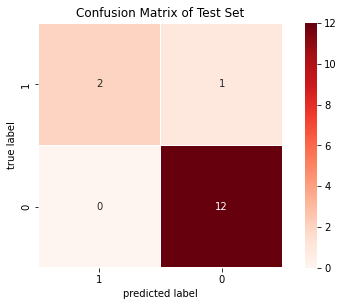

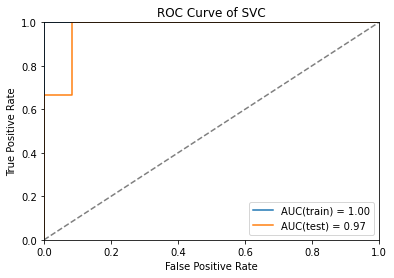

/content/drive/My Drive/Colab Notebooks/eli5/formatters/html.py:233: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,MAST4-AS1
0 ± 0.0000,ARG2
0 ± 0.0000,FAM49B
0 ± 0.0000,ARMC3
0 ± 0.0000,TRBV7-4
0 ± 0.0000,TCERG1
0 ± 0.0000,DDX11L8
0 ± 0.0000,NDRG3
0 ± 0.0000,C20orf96
0 ± 0.0000,MMRN1


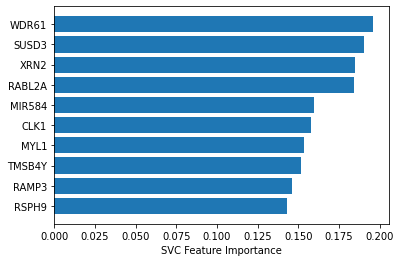

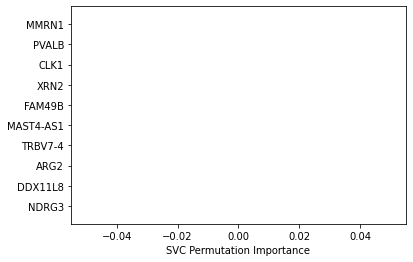

In [ ]:
svc(df_1, 1)

trainset accuracy: 1.00, testset accuracy: 1.00
precision: 1.00, sensitivity: 1.00, specificity: 1.00, F1-score: 1.00


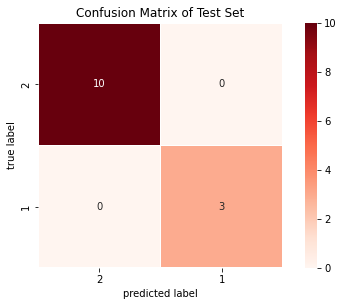

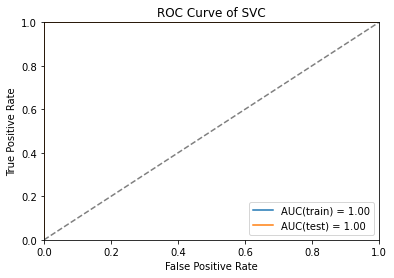

/content/drive/My Drive/Colab Notebooks/eli5/formatters/html.py:233: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,S100A13
0 ± 0.0000,COMMD5
0 ± 0.0000,MT1F
0 ± 0.0000,ANXA1
0 ± 0.0000,TTR
0 ± 0.0000,ASS1
0 ± 0.0000,LINC00844
0 ± 0.0000,GSTA2
0 ± 0.0000,TSPAN7
0 ± 0.0000,RAMP3


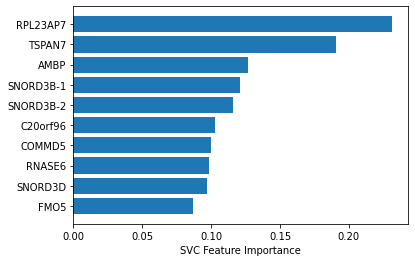

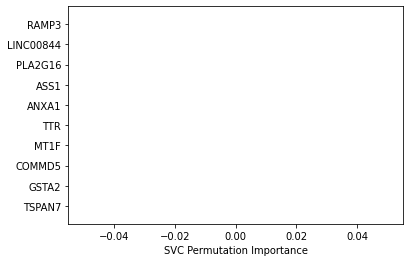

In [ ]:
svc(df_2, 2)

trainset accuracy: 1.00, testset accuracy: 0.80
precision: 0.50, sensitivity: 1.00, specificity: 0.60, F1-score: 0.67


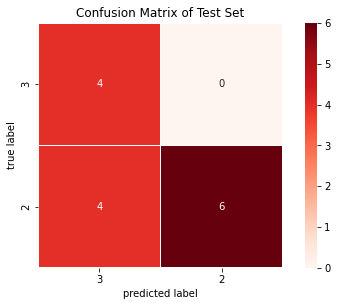

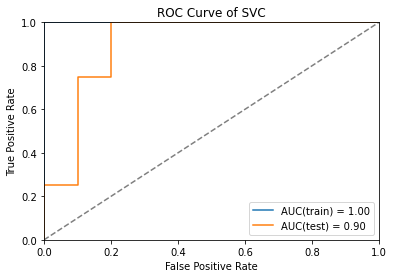

Weight,Feature
0.0333 ± 0.0381,TPM2
0.0238 ± 0.0602,MTCH2
0.0095 ± 0.0233,CD52
0 ± 0.0000,CFHR2
0 ± 0.0000,ADH4
0 ± 0.0000,AMBP
0 ± 0.0000,SHMT1
0 ± 0.0000,ACAA2
0 ± 0.0000,ADH1B
0 ± 0.0000,APOC3


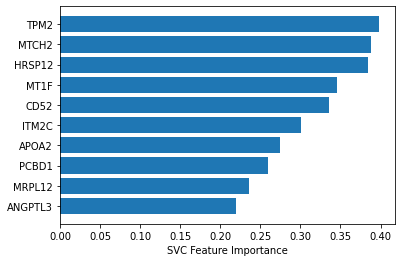

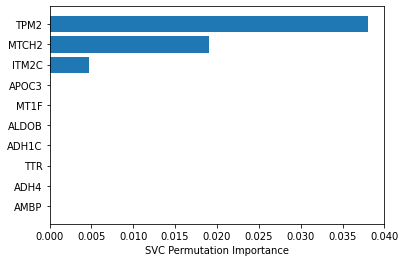

In [ ]:
svc(df_3, 3)

# Select important gene using SVC-RFECV

In [ ]:
def SVC_RFECV(df, pos_label):
  # define dataset and label
  X = df.drop(['label'], axis = 1)
  y = df['label']

  # split the dataset to trainset and testset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True, stratify = y)

  # train the model
  svc = SVC(kernel = 'linear', probability = True, class_weight = 'balanced')
  svc.fit(X_train, y_train)
  rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
                scoring='accuracy')
  rfecv.fit(X_train, y_train)

  # prediction
  pred_train = rfecv.predict(X_train)
  pred_test = rfecv.predict(X_test)
  
  # accuracy
  train_acc = balanced_accuracy_score(y_train, pred_train)
  test_acc = balanced_accuracy_score(y_test, pred_test)
  print ("trainset accuracy: {0:.2f}, testset accuracy: {1:.2f}".format(train_acc, test_acc))
  
  # other four evaluation matrix
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    CM = confusion_matrix(y_test, pred_test, labels = [0, 1])
  elif (set(df['label']) == {0, 1}) & (pos_label == 1): 
    CM = confusion_matrix(y_test, pred_test, labels = [1, 0])
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    CM = confusion_matrix(y_test, pred_test, labels = [1, 2])
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 1])
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 3])  
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    CM = confusion_matrix(y_test, pred_test, labels = [3, 2])      
  precision = CM[0, 0] / (CM[0, 0] + CM[1, 0])
  sensitivity = CM[0, 0] / (CM[0, 0] + CM[0, 1])
  specificity = CM[1, 1]/(CM[1, 0] + CM[1, 1])
  F1 = (2 * precision * sensitivity) / (precision + sensitivity)
  print("precision: {0:.2f}, sensitivity: {1:.2f}, specificity: {2:.2f}, F1-score: {3:.2f}".format(precision, sensitivity, specificity, F1))  

  # plot heatmap for confusion matrix
  fig, ax = plt.subplots(figsize=(8, 4.5))
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    tick_label = [0, 1]
  elif (set(df['label']) == {0, 1}) & (pos_label == 1):
    tick_label = [1, 0]
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    tick_label = [1, 2]
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    tick_label = [2, 1]
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    tick_label = [2, 3]
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    tick_label = [3, 2]
  sns.heatmap(CM, fmt='.0f', cmap="Reds",
              square=True, linewidths=.5, annot=True, xticklabels = tick_label, yticklabels = tick_label)
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.title('Confusion Matrix of Test Set')
  plt.show()

  # plot ROC Cruve 
  labels = np.unique(df['label'].to_numpy())
  if pos_label == labels[0]:
    class_index = 0
  elif pos_label == labels[1]:
    class_index = 1
  prob_train = svc.predict_proba(X_train)
  predict_train = prob_train[:, class_index]
  fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predict_train, pos_label = pos_label)

  prob_test = svc.predict_proba(X_test)
  predict_test = prob_test[:, class_index]
  fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predict_test, pos_label = pos_label)

  roc_auc_train = auc(fpr_train, tpr_train)
  roc_auc_test = auc(fpr_test, tpr_test)
  # plt.figure(figsize = (8, 4.5))
  plt.title("ROC Curve of RFECV-SVC")
  plt.plot(fpr_train, tpr_train, label="AUC(train) = %0.2f" % roc_auc_train)
  plt.plot(fpr_test, tpr_test, label="AUC(test) = %0.2f" % roc_auc_test)
  plt.legend(loc="lower right")
  plt.plot([0, 1], [0, 1],  color='grey', linestyle='--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.show()
  
  print(rfecv.get_feature_names_out())

  plt.figure(figsize=(6, 4))
  perm_importance = permutation_importance(rfecv, X_train, y_train)
  sorted_idx = perm_importance.importances_mean.argsort()
  plt.barh(X_train.columns[sorted_idx][-10: ], perm_importance.importances_mean[sorted_idx][-10: ])
  plt.xlabel("RFECV-SVC Permutation Importance")

  perm = PermutationImportance(rfecv).fit(X_train, y_train)
  return eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,


trainset accuracy: 1.00, testset accuracy: 0.79
precision: 0.67, sensitivity: 0.67, specificity: 0.92, F1-score: 0.67


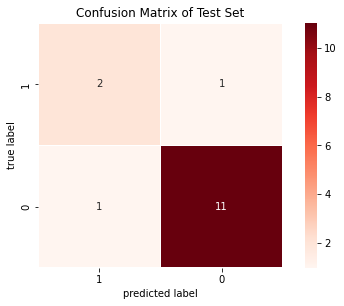

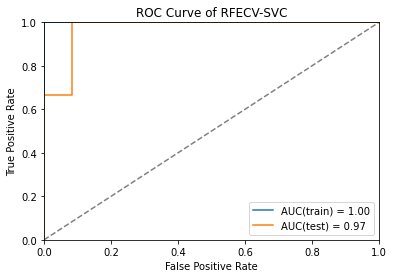

['MIR584' 'RABL2A' 'RAMP3' 'FLJ43681' 'RPL23AP82' 'BCLAF1' 'TSPAN2' 'FOS'
 'MYL1' 'ADORA2A' 'LSM5' 'MYL4' 'DUSP1' 'TCERG1' 'C20orf96' 'DDX11L8'
 'ARG2' 'MAST4-AS1' 'FAM49B' 'XRN2' 'CLK1' 'ARMC3' 'LTV1' 'SLC6A6' 'SUSD3'
 'MRPS17' 'TMSB4Y' 'LRMP' 'RSPH9' 'ANGPT1' 'PLXDC2' 'JAM3' 'NOP16'
 'FAM212B-AS1' 'LPAR5' 'CABP5' 'WDR61' 'MYEOV' 'TESPA1' 'PVALB' 'MMRN1']


/content/drive/My Drive/Colab Notebooks/eli5/formatters/html.py:233: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,MAST4-AS1
0 ± 0.0000,ARG2
0 ± 0.0000,FAM49B
0 ± 0.0000,ARMC3
0 ± 0.0000,TRBV7-4
0 ± 0.0000,TCERG1
0 ± 0.0000,DDX11L8
0 ± 0.0000,NDRG3
0 ± 0.0000,C20orf96
0 ± 0.0000,MMRN1


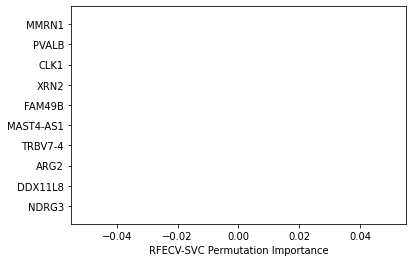

In [ ]:
SVC_RFECV(df_1, 1)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,


trainset accuracy: 1.00, testset accuracy: 1.00
precision: 1.00, sensitivity: 1.00, specificity: 1.00, F1-score: 1.00


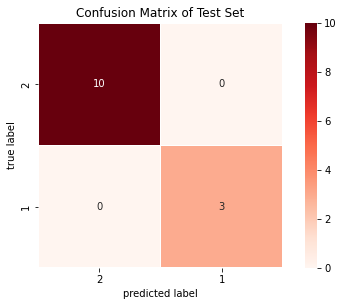

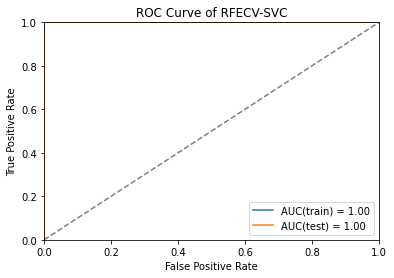

['CHMP4C' 'CPB2' 'LUC7L3' 'AKR1C1' 'PLA2G16' 'ANXA1' 'COMMD5' 'TSPAN7'
 'S100A13' 'SNORD3B-2' 'SNORD3D' 'SNORD3B-1' 'RPL23AP7']


Weight,Feature
0.0051 ± 0.0205,TSPAN7
0 ± 0.0000,S100A13
0 ± 0.0000,COMMD5
0 ± 0.0000,MT1F
0 ± 0.0000,ANXA1
0 ± 0.0000,TTR
0 ± 0.0000,ASS1
0 ± 0.0000,LINC00844
0 ± 0.0000,GSTA2
0 ± 0.0000,RAMP3


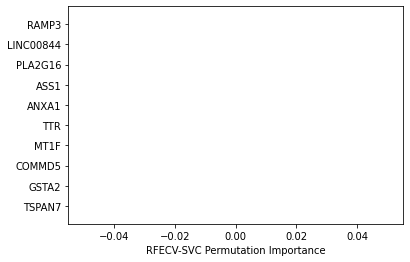

In [ ]:
SVC_RFECV(df_2, 2)

trainset accuracy: 0.93, testset accuracy: 0.95
precision: 0.80, sensitivity: 1.00, specificity: 0.90, F1-score: 0.89


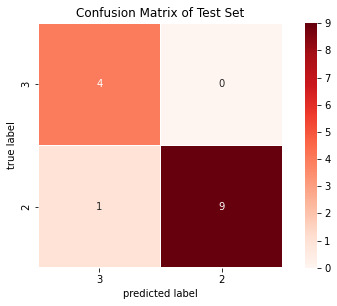

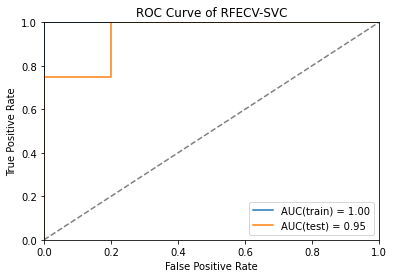

['MTCH2' 'FCER1A']


Weight,Feature
0.2333 ± 0.1457,MTCH2
0.0952 ± 0.0797,FCER1A
0 ± 0.0000,ADH1C
0 ± 0.0000,CFHR2
0 ± 0.0000,ADH4
0 ± 0.0000,AMBP
0 ± 0.0000,SHMT1
0 ± 0.0000,ACAA2
0 ± 0.0000,ADH1B
0 ± 0.0000,APOC3


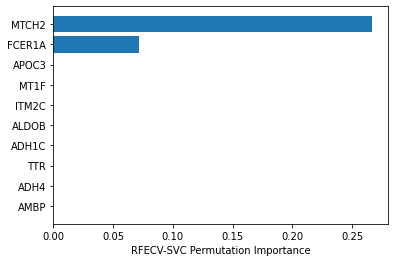

In [ ]:
SVC_RFECV(df_3, 3)

# Select important genes using XGBoost

In [ ]:
def XGB(df, pos_label):
  # define dataset and label
  X = df.drop(['label'], axis = 1)
  y = df['label']

  # split the dataset to trainset and testset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True, stratify = y)

  # train the model
  xgb = XGBClassifier()
  xgb.fit(X_train, y_train)

  # prediction
  pred_train = xgb.predict(X_train)
  pred_test = xgb.predict(X_test)
  
  # accuracy
  train_acc = balanced_accuracy_score(y_train, pred_train)
  test_acc = balanced_accuracy_score(y_test, pred_test)
  print ("trainset accuracy: {0:.2f}, testset accuracy: {1:.2f}".format(train_acc, test_acc))
  
  # other four evaluation metrics
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    CM = confusion_matrix(y_test, pred_test, labels = [0, 1])
  elif (set(df['label']) == {0, 1}) & (pos_label == 1): 
    CM = confusion_matrix(y_test, pred_test, labels = [1, 0])
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    CM = confusion_matrix(y_test, pred_test, labels = [1, 2])
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 1])
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    CM = confusion_matrix(y_test, pred_test, labels = [2, 3])  
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    CM = confusion_matrix(y_test, pred_test, labels = [3, 2])     
  precision = CM[0, 0] / (CM[0, 0] + CM[1, 0])
  sensitivity = CM[0, 0] / (CM[0, 0] + CM[0, 1])
  specificity = CM[1, 1]/(CM[1, 0] + CM[1, 1])
  F1 = (2 * precision * sensitivity) / (precision + sensitivity)
  print("precision: {0:.2f}, sensitivity: {1:.2f}, specificity: {2:.2f}, F1-score: {3:.2f}".format(precision, sensitivity, specificity, F1))  

  # plot heatmap for confusion matrix
  fig, ax = plt.subplots(figsize=(8, 4.5))
  if (set(df['label']) == {0, 1}) & (pos_label == 0):
    tick_label = [0, 1]
  elif (set(df['label']) == {0, 1}) & (pos_label == 1):
    tick_label = [1, 0]
  elif (set(df['label']) == {1, 2}) & (pos_label == 1):
    tick_label = [1, 2]
  elif (set(df['label']) == {1, 2}) & (pos_label == 2):
    tick_label = [2, 1]
  elif (set(df['label']) == {2, 3}) & (pos_label == 2):
    tick_label = [2, 3]
  elif (set(df['label']) == {2, 3}) & (pos_label == 3):
    tick_label = [3, 2]
  sns.heatmap(CM, fmt='.0f', cmap="Reds",
              square=True, linewidths=.5, annot=True, xticklabels = tick_label, yticklabels = tick_label)
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.title('Confusion Matrix of Test Set')
  plt.show()
  
  # plot ROC Cruve 
  labels = np.unique(df['label'].to_numpy())
  if pos_label == labels[0]:
    class_index = 0
  elif pos_label == labels[1]:
    class_index = 1
  prob_train = xgb.predict_proba(X_train)
  predict_train = prob_train[:, class_index]
  fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predict_train, pos_label = pos_label)

  prob_test = xgb.predict_proba(X_test)
  predict_test = prob_test[:, class_index]
  fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predict_test, pos_label = pos_label)

  roc_auc_train = auc(fpr_train, tpr_train)
  roc_auc_test = auc(fpr_test, tpr_test)

  plt.title("ROC Curve of RandomForest")
  plt.plot(fpr_train, tpr_train, label="AUC(train) = %0.2f" % roc_auc_train)
  plt.plot(fpr_test, tpr_test, label="AUC(test) = %0.2f" % roc_auc_test)
  plt.legend(loc="lower right")
  plt.plot([0, 1], [0, 1],  color='grey', linestyle='--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  
  plt.figure(figsize=(6, 4))
  sorted_idx = xgb.feature_importances_.argsort()
  plt.xlabel("XGB Feature Importance")
  plt.barh(X_train.columns[sorted_idx][-10: ], xgb.feature_importances_[sorted_idx][-10: ])

  plt.figure(figsize=(6, 4))
  perm_importance = permutation_importance(xgb, X_train, y_train)
  sorted_idx = perm_importance.importances_mean.argsort()
  plt.barh(X_train.columns[sorted_idx][-10: ], perm_importance.importances_mean[sorted_idx][-10: ])
  plt.xlabel("XGB Permutation Importance")

  perm = PermutationImportance(xgb).fit(X_train, y_train)
  return eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top = 10)

trainset accuracy: 1.00, testset accuracy: 0.67
precision: 1.00, sensitivity: 0.33, specificity: 1.00, F1-score: 0.50


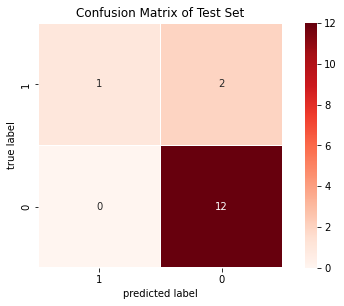

Weight,Feature
0.0429 ± 0.0356,BCLAF1
0.0333 ± 0.0486,RABL2A
0.0190 ± 0.0190,FLJ43681
0.0143 ± 0.0233,LSM5
0.0095 ± 0.0233,DUSP1
0.0095 ± 0.0233,ADORA2A
0 ± 0.0000,TRBV7-4
0 ± 0.0000,DDX11L8
0 ± 0.0000,ARG2
0 ± 0.0000,TSPAN2


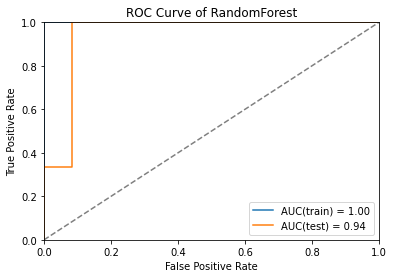

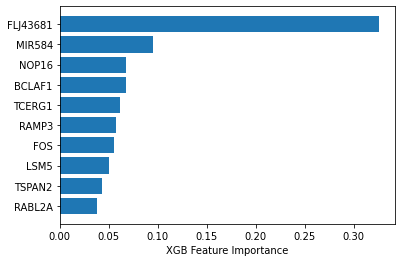

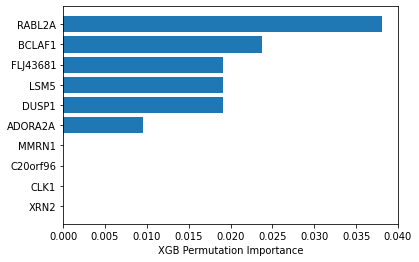

In [ ]:
XGB(df_1, 1)

trainset accuracy: 1.00, testset accuracy: 0.78
precision: 0.90, sensitivity: 0.90, specificity: 0.67, F1-score: 0.90


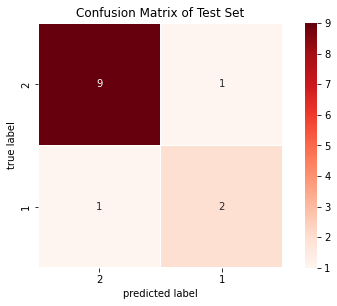

Weight,Feature
0.0974 ± 0.0598,FABP1
0.0103 ± 0.0251,RPL23AP7
0 ± 0.0000,MT1F
0 ± 0.0000,TTR
0 ± 0.0000,ASS1
0 ± 0.0000,ANXA1
0 ± 0.0000,LINC00844
0 ± 0.0000,TSPAN7
0 ± 0.0000,COMMD5
0 ± 0.0000,GSTA2


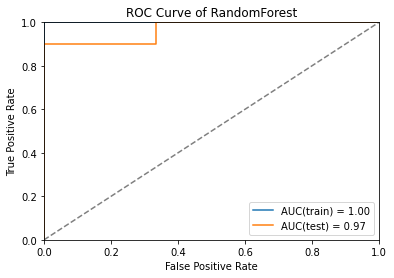

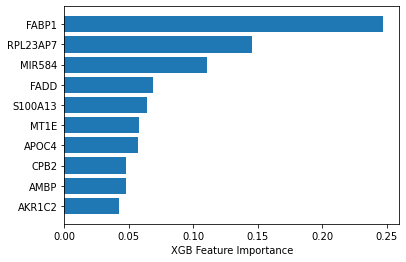

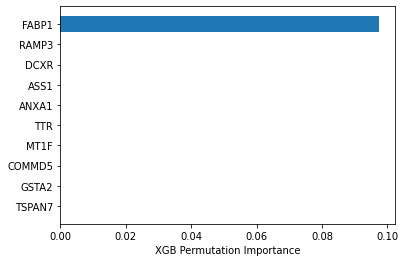

In [ ]:
XGB(df_2, 2)

trainset accuracy: 1.00, testset accuracy: 0.85
precision: 0.57, sensitivity: 1.00, specificity: 0.70, F1-score: 0.73


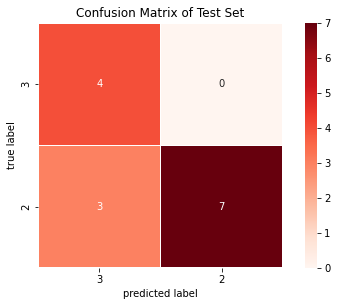

Weight,Feature
0.0571 ± 0.0233,MTCH2
0.0238 ± 0.0000,MRPL40
0.0190 ± 0.0190,ETFB
0.0143 ± 0.0381,PTPN6
0 ± 0.0000,ADH1B
0 ± 0.0000,TTR
0 ± 0.0000,ADH4
0 ± 0.0000,AMBP
0 ± 0.0000,SHMT1
0 ± 0.0000,APOC3


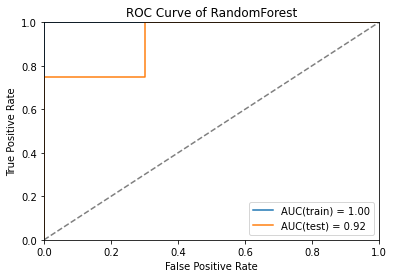

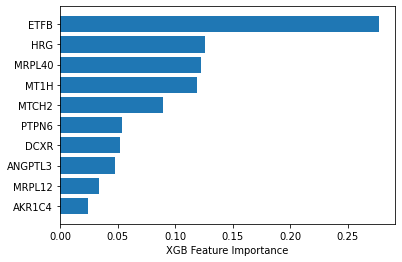

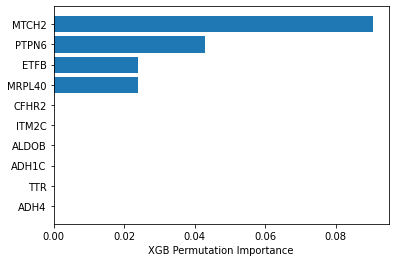

In [ ]:
XGB(df_3, 3)

# Plot learning curve for different model evaluation metrics

In [ ]:
from operator import pos
# define a function to plot learning curve for one model
def plot_learning_curve(estimator, df, label, metrics):
   # define dataset and label
  X = df.drop(['label'], axis = 1)
  y = df['label']
  
  train_set_size, train_scores, test_scores = learning_curve(estimator, X, y, cv = None, scoring = metrics)
  plt.plot(train_set_size,train_scores.mean(axis=1), '--', label = label + ' train ')
  plt.plot(train_set_size,test_scores.mean(axis=1), '-', label = label + ' test ')
  plt.xlabel('Train Set Size')
  plt.ylabel(metrics)
  plt.legend(loc='lower right')

In [ ]:
# define the estimators
def estimators(df):
  # define dataset and label
  X = df.drop(['label'], axis = 1)
  y = df['label']

  # split the dataset to trainset and testset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True, stratify = y)

  # train the model
  dtree = DecisionTreeClassifier(criterion="entropy", random_state=123,
                                max_depth=4,
                                min_samples_leaf=5, class_weight = 'balanced')
  dtree.fit(X_train, y_train)

  # Random forest
  forest = RandomForestClassifier(
      n_estimators=10, criterion="entropy",
      max_depth=4, min_samples_leaf=5, class_weight = 'balanced')
  forest.fit(X_train, y_train)

  # SVC
  svc = SVC(kernel = 'linear', probability = True, class_weight = 'balanced')
  svc.fit(X_train, y_train)

  # SCV-RFECV
  svc = SVC(kernel = 'linear', probability = True, class_weight = 'balanced')
  svc.fit(X_train, y_train)
  rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
                scoring='accuracy')
  rfecv.fit(X_train, y_train)

  # XGBoost
  xgb = XGBClassifier()
  xgb.fit(X_train, y_train)

  return dtree, forest, svc, rfecv, xgb

In [ ]:
# define a function to plot the learning curve for all models in one graph
def learning_curve_all(df, metrics):
  
  ''' 
  metrics: model evaluation metrics
  1. 'accuracy'
  2. 'balanced accuracy'
  3. 'precision'
  4. 'recall'
  5. 'f1'
  '''

  plt.figure(figsize = (10, 6))
  group_1_labels = [0, 1]
  group_2_labels = [1, 2]
  group_3_labels = [2, 3]
  df_labels = list(np.unique(df['label'].to_numpy()))
  if  df_labels == group_1_labels:
    group = 'HV-PA'
  elif df_labels == group_2_labels:
    group = 'PA-PV'
  elif df_labels == group_3_labels:
    group = 'PV-PoV'
  plt.title('Learning Curve in ' + group + ' ({})'.format(metrics))
  plot_learning_curve(estimators(df)[0], df, 'DT', metrics)
  plot_learning_curve(estimators(df)[1], df, 'RF', metrics)
  plot_learning_curve(estimators(df)[2], df, 'SVC', metrics)
  plot_learning_curve(estimators(df)[3], df, 'RFECV-SVC', metrics)
  plot_learning_curve(estimators(df)[4], df, 'XGB', metrics)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted sample

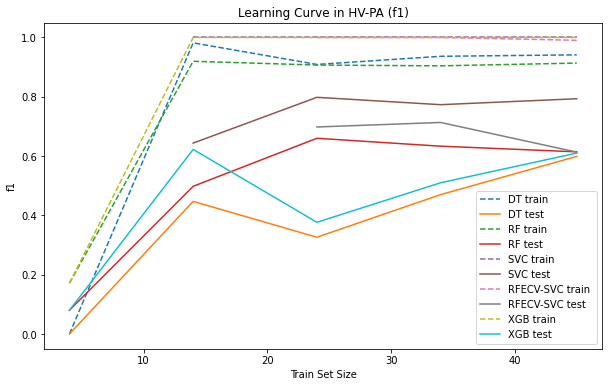

In [ ]:
learning_curve_all(df_1, 'f1')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

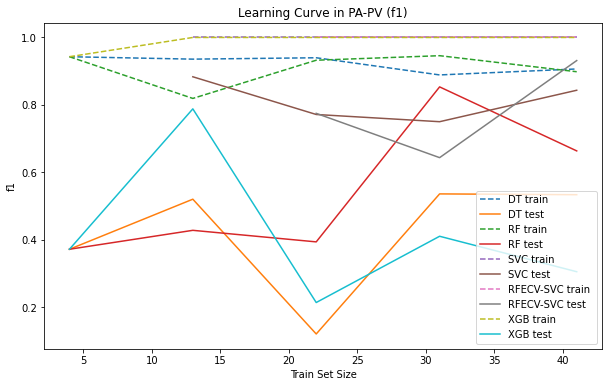

In [ ]:
learning_curve_all(df_2, 'f1')

In [ ]:
df_3['label'] = df_3['label'] - 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


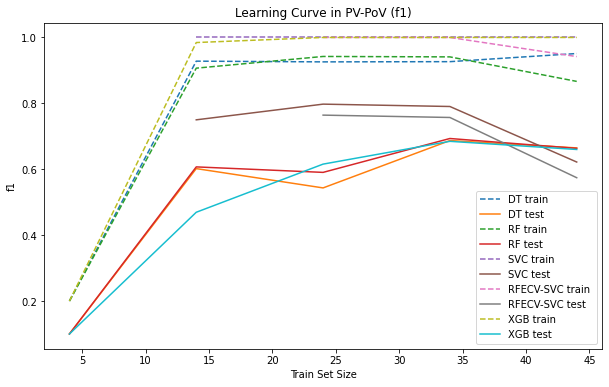

In [ ]:
learning_curve_all(df_3, 'f1', 'PV-PoV')

# Dimension reduction

Perform PCA

In [ ]:
def pca_func(df, num_components):
  # # get eigenvalues(ew) and eigenvector(ev)
  # ew, ev = np.linalg.eig(np.cov(df.T))
  # # sort the eigenvalues and eigenvectors 
  # ew_order = np.argsort(ew)[::-1]
  # ew_sort = ew[ew_order]
  # ev_sort = ev[:, ew_order]
  # # generate the new vector
  # V = ev_sort[:, :n_features]
  # X_new = df.dot(V)

  # print the size of dataframe
  print('Size of the dataframe: {}'.format(df.shape))
  # get the label of columns
  feat_cols = list(df.drop('label', axis = 1).columns)

  # define the model
  pca = PCA(n_components = num_components)
  pca_result = pca.fit_transform(df[feat_cols].values)

  # storage the selected features
  df_pca = pd.DataFrame(columns = ['PC-1', 'PC-2', 'PC-3'])
  df_pca['PC-1'] = pca_result[:,0]
  df_pca['PC-2'] = pca_result[:,1] 
  df_pca['PC-3'] = pca_result[:,2]

  # insert label for selected pcs
  df_pca.insert(df_pca.shape[1], 'label', df[['label']])
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

  return df_pca

In [ ]:
df_pca_g1 = pca_func(df_1, 3)

Size of the dataframe: (57, 53)
Explained variation per principal component: [0.38166547 0.08888277 0.06566272]


In [ ]:
df_pca_g2 = pca_func(df_2, 3)

Size of the dataframe: (52, 86)
Explained variation per principal component: [0.46936082 0.10014051 0.06488668]


In [ ]:
df_pca_g3 = pca_func(df_3, 3)

Size of the dataframe: (56, 59)
Explained variation per principal component: [0.49489592 0.13384306 0.0536486 ]


Perform t-SNE

In [ ]:
def t_SNE(df, num_component):

  # print the size of dataframe
  print('Size of the dataframe: {}'.format(df.shape))

  tsne = TSNE(n_components= num_component, verbose = 0, perplexity = 30, n_iter= 5000, random_state = 43, init = 'pca')
  tsne_results = tsne.fit_transform(df)

  # storage the selected features
  df_tsne = pd.DataFrame(columns = ['tsne-1', 'tsne-2', 'tsne-3'])
  df_tsne['tsne-1'] = tsne_results[:,0]
  df_tsne['tsne-2'] = tsne_results[:,1]
  df_tsne['tsne-3'] = tsne_results[:,2]

  # insert label for selected pcs
  df_tsne.insert(df_tsne.shape[1], 'label', df[['label']])

  # plot the running time
  time_start = time.time()
  print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

  return df_tsne

In [ ]:
df_tsne_g1 = t_SNE(df_1, 3)

Size of the dataframe: (57, 53)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


t-SNE done! Time elapsed: 1.1920928955078125e-06 seconds


In [ ]:
df_tsne_g2 = t_SNE(df_2, 3)

Size of the dataframe: (52, 86)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


t-SNE done! Time elapsed: 1.1920928955078125e-06 seconds


In [ ]:
df_tsne_g3 = t_SNE(df_3, 3)

Size of the dataframe: (56, 59)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


t-SNE done! Time elapsed: 9.5367431640625e-07 seconds


Define functions for visualizations

In [ ]:
# comparision between PCA and t-SNE
def pca_tsne_comp(df_pca, df_tsne, title):
  plt.figure(figsize=(12,5))
  ax1 = plt.subplot(1, 2, 1)
  sns.scatterplot(
      x="PC-1", y="PC-2",
      hue="label",
      palette=sns.color_palette("hls", 2),
      data=df_pca,
      legend="full",
      # alpha=0.3,
      ax=ax1
  )
  plt.title('The PCA Result in ' + str(title))
  ax2 = plt.subplot(1, 2, 2)
  sns.scatterplot(
      x="tsne-1", y="tsne-2",
      hue="label",
      palette=sns.color_palette("hls", 2),
      data=df_tsne,
      legend="full",
      # alpha=0.3,
      ax=ax2
  )
  plt.title('The T-SNE Result in ' + str(title))

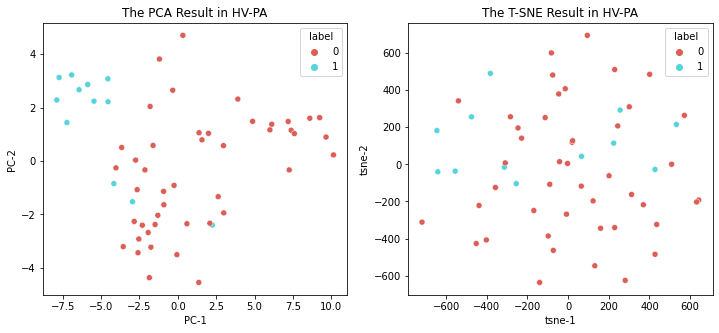

In [ ]:
pca_tsne_comp(df_pca_g1, df_tsne_g1, 'HV-PA')

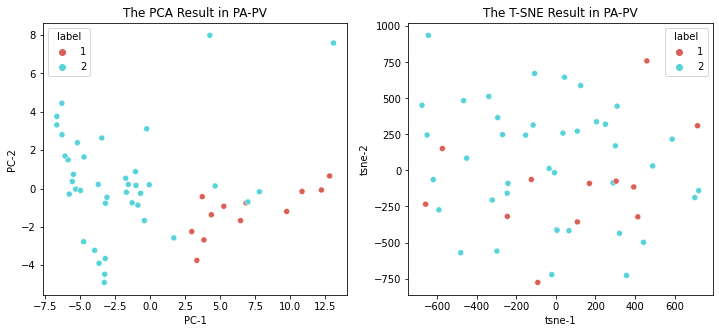

In [ ]:
pca_tsne_comp(df_pca_g2, df_tsne_g2, 'PA-PV')

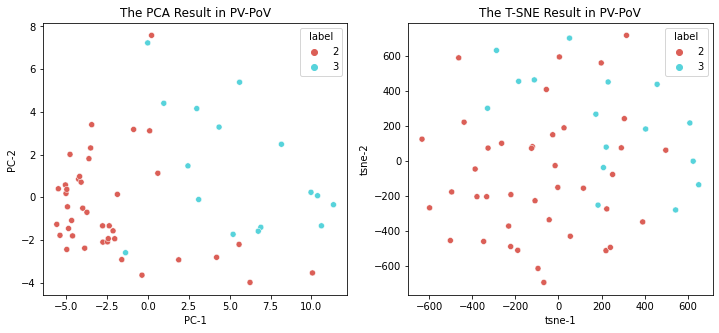

In [ ]:
pca_tsne_comp(df_pca_g3, df_tsne_g3, 'PV-PoV')

In [ ]:
# define a function to plot 3-D scatter plot 
def scatter_3D(df, title):
  if df.columns[0] == 'PC-1':
    ax = plt.figure(figsize=(10, 6)).gca(projection='3d')
    ax.scatter(
        xs=df["PC-1"], 
        ys=df["PC-2"], 
        zs=df["PC-3"], 
        c=df["label"], 
        cmap='bwr',
    )
  elif df.columns[0] == 'tsne-1':
    ax = plt.figure(figsize=(10, 6)).gca(projection='3d')
    ax.scatter(
        xs=df["tsne-1"], 
        ys=df["tsne-2"], 
        zs=df["tsne-3"], 
        c=df["label"], 
        cmap='bwr',
    )
  elif df.columns[0] == 'tsne-pca50-1':
    ax = plt.figure(figsize=(10, 6)).gca(projection='3d')
    ax.scatter(
        xs=df["tsne-pca50-1"], 
        ys=df["tsne-pca50-2"], 
        zs=df["tsne-pca50-3"], 
        c=df["label"], 
        cmap='bwr',
    )

  plt.title('The 3D distribution of samples in ' + str(title))
  ax.set_xlabel('PC-1')
  ax.set_ylabel('PC-2')
  ax.set_zlabel('PC-3')
  plt.show()

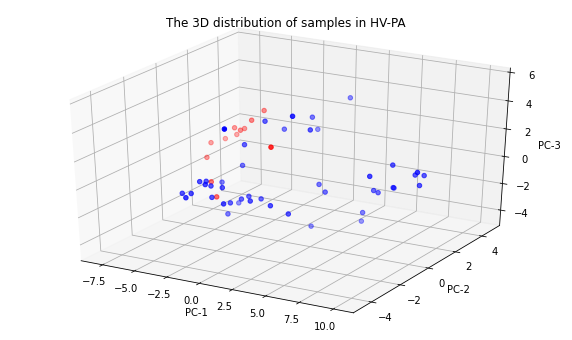

In [ ]:
scatter_3D(df_pca_g1, 'HV-PA')

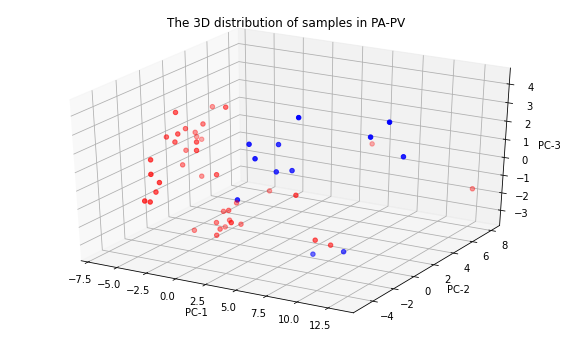

In [ ]:
scatter_3D(df_pca_g2, 'PA-PV')

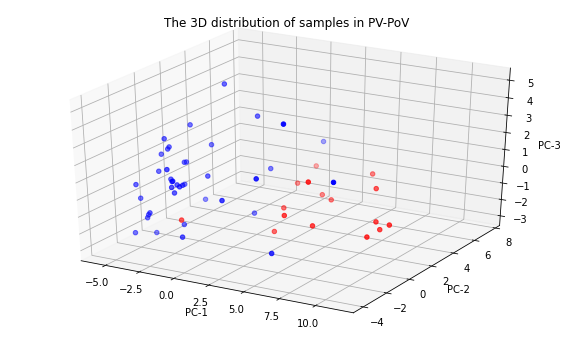

In [ ]:
scatter_3D(df_pca_g3, 'PV-PoV')